In [116]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics


In [118]:
PATH = "data/"

In [119]:
!ls {PATH}

submission_example.csv
test.csv
train.csv


In [120]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [121]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [122]:
display_all(df_raw.tail().T)

,328,329,330,331,332
ID,500.00000,502.00000,503.00000,504.00000,506.00000
crim,0.17783,0.06263,0.04527,0.06076,0.04741
zn,0.00000,0.00000,0.00000,0.00000,0.00000
indus,9.69000,11.93000,11.93000,11.93000,11.93000
chas,0.00000,0.00000,0.00000,0.00000,0.00000
nox,0.58500,0.57300,0.57300,0.57300,0.57300
rm,5.56900,6.59300,6.12000,6.97600,6.03000
age,73.50000,69.10000,76.70000,91.00000,80.80000
dis,2.39990,2.47860,2.28750,2.16750,2.50500
rad,6.00000,1.00000,1.00000,1.00000,1.00000


In [123]:
display_all(df_raw.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
ID,333.0,250.951952,147.859438,1.00000,123.00000,244.00000,377.00000,506.0000
crim,333.0,3.360341,7.352272,0.00632,0.07896,0.26169,3.67822,73.5341
zn,333.0,10.689189,22.674762,0.00000,0.00000,0.00000,12.50000,100.0000
indus,333.0,11.293483,6.998123,0.74000,5.13000,9.90000,18.10000,27.7400
chas,333.0,0.060060,0.237956,0.00000,0.00000,0.00000,0.00000,1.0000
nox,333.0,0.557144,0.114955,0.38500,0.45300,0.53800,0.63100,0.8710
rm,333.0,6.265619,0.703952,3.56100,5.88400,6.20200,6.59500,8.7250
age,333.0,68.226426,28.133344,6.00000,45.40000,76.70000,93.80000,100.0000
dis,333.0,3.709934,1.981123,1.12960,2.12240,3.09230,5.11670,10.7103
rad,333.0,9.633634,8.742174,1.00000,4.00000,5.00000,24.00000,24.0000


In [124]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('medv', axis=1), df_raw.medv)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [125]:
df, y, nas = proc_df(df_raw, 'medv')


In [126]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.8958166145316727

In [127]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 200
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape


((133, 14), (133,), (200, 14))

In [128]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res=[rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
         m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [129]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 112 ms
[1.5120722224864258, 5.867771553153719, 0.958449366414311, 0.6659946113327169]


In [130]:
m=RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=1)
m.fit(X_train, y_train)
print_score(m)

[2.0651979670816383, 6.41214131442701, 0.9224903175322064, 0.6011466455737705]


In [131]:
df_trn, y_trn, nas = proc_df(df_raw, 'medv', subset=200, na_dict=nas)
X_train, _ = split_vals(df_trn, 150)
y_train, _ = split_vals(y_trn, 150)

In [132]:
m=RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0, 4.341117367683117, 1.0, 0.8171857124590209]


In [168]:
m=RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_code(code=<code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 43, 144359, tzinfo=tzutc()), 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'35756be62e4d4edcb5bad7194d20b083']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 43, 144359, tzinfo=tzutc()), 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'35756be62e4d4edcb5bad7194d20b083'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 43, 144359, tzinfo=tzutc()), 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9ab6b90d7c5240d4976ef38062b5feb1', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='m=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'm=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('m=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('m=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='m=RandomForestRegressor(n_jobs=-1)\nm.fit(X_train, y_train)\nprint_score(m)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-168-be7b82f998fa>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 236871a3d30, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000023687138390, file "<ipython-input-168-be7b82f998fa>", line 2>
        result = <ExecutionResult object at 236871a3d30, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000023687138390, file "<ipython-input-168-be7b82f998fa>", line 2>, result=<ExecutionResult object at 236871a3d30, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000023687138390, file "<ipython-input-168-be7b82f998fa>", line 2>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\anshu\Documents\Google Drive\kaggle\boston\model\<ipython-input-168-be7b82f998fa> in <module>()
      1 m=RandomForestRegressor(n_jobs=-1)
----> 2 m.fit(X_train, y_train)
      3 print_score(m)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 9
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Mar 26 23:08:43 2018
PID: 39020    Python 3.6.4: C:\Users\anshu\Anaconda3\envs\fastai\python.exe
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1418162487, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 10), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1418162487, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 10)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1418162487, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None, tree_idx=0, n_trees=10, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1418162487, splitter='best')>
        X = array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32)
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        sample_weight = None
        curr_sample_weight = array([1., 0., 2., 3., 0., 1., 1., 1., 1., 1., 1... 1., 1., 0., 0., 2., 3., 2., 0., 1., 0., 1., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1418162487, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([1., 0., 2., 3., 0., 1., 1., 1., 1., 1., 1... 1., 1., 0., 0., 2., 3., 2., 0., 1., 0., 1., 1.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1418162487, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([1., 0., 2., 3., 0., 1., 1., 1., 1., 1., 1... 1., 1., 0., 0., 2., 3., 2., 0., 1., 0., 1., 1.]), check_input=False, X_idx_sorted=None)
    231 
    232         self.max_features_ = max_features
    233 
    234         if len(y) != n_samples:
    235             raise ValueError("Number of labels=%d does not match "
--> 236                              "number of samples=%d" % (len(y), n_samples))
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        n_samples = 150
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=133 does not match number of samples=150
___________________________________________________________________________

In [167]:
preds=np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

ValueError: need at least one array to stack

In [135]:
preds.shape


(10, 200)

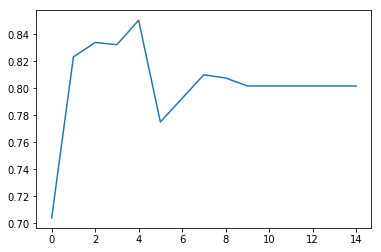

In [138]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(15)]);

In [139]:
m=RandomForestRegressor(n_estimators=5, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.325565616051902, 5.0809428258936356, 0.8813540922277466, 0.7495646134117173]


In [140]:
m=RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[2.5587196016758065, 4.054605899467912, 0.929762812413645, 0.840520680173278]


In [141]:
m=RandomForestRegressor(n_estimators=15, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[2.161529362554482, 4.697619255183063, 0.9498761986730286, 0.7859265999062378]


In [142]:
m=RandomForestRegressor(n_estimators=25, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[2.2216761000049794, 4.614985486434383, 0.9470478976896194, 0.7933917029996599]


In [143]:
m=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[2.197844133084358, 4.639300209891574, 0.9481778412071254, 0.7912088760040847, 0.8219957473698831]


In [166]:
m=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_code(code=<code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 28, 755348, tzinfo=tzutc()), 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'35756be62e4d4edcb5bad7194d20b083']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 28, 755348, tzinfo=tzutc()), 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'35756be62e4d4edcb5bad7194d20b083'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 28, 755348, tzinfo=tzutc()), 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca222de877eb4209bf97d479ae4779ef', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='m=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'm=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('m=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('m=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='m=RandomForestRegressor(n_estimators=40, n_jobs=...core=True)\nm.fit(X_train, y_train)\nprint_score(m)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-166-4b4b3320e55c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 23687069e48, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000023687138AE0, file "<ipython-input-166-4b4b3320e55c>", line 2>
        result = <ExecutionResult object at 23687069e48, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000023687138AE0, file "<ipython-input-166-4b4b3320e55c>", line 2>, result=<ExecutionResult object at 23687069e48, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000023687138AE0, file "<ipython-input-166-4b4b3320e55c>", line 2>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\anshu\Documents\Google Drive\kaggle\boston\model\<ipython-input-166-4b4b3320e55c> in <module>()
      1 m=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
----> 2 m.fit(X_train, y_train)
      3 print_score(m)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 39
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Mar 26 23:08:29 2018
PID: 39020    Python 3.6.4: C:\Users\anshu\Anaconda3\envs\fastai\python.exe
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1919472048, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 40), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1919472048, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 40)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1919472048, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None, tree_idx=0, n_trees=40, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1919472048, splitter='best')>
        X = array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32)
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        sample_weight = None
        curr_sample_weight = array([1., 0., 2., 1., 2., 2., 0., 0., 3., 0., 0... 1., 1., 1., 0., 1., 1., 1., 0., 2., 1., 3., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1919472048, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([1., 0., 2., 1., 2., 2., 0., 0., 3., 0., 0... 1., 1., 1., 0., 1., 1., 1., 0., 2., 1., 3., 1.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1919472048, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([1., 0., 2., 1., 2., 2., 0., 0., 3., 0., 0... 1., 1., 1., 0., 1., 1., 1., 0., 2., 1., 3., 1.]), check_input=False, X_idx_sorted=None)
    231 
    232         self.max_features_ = max_features
    233 
    234         if len(y) != n_samples:
    235             raise ValueError("Number of labels=%d does not match "
--> 236                              "number of samples=%d" % (len(y), n_samples))
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        n_samples = 150
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=133 does not match number of samples=150
___________________________________________________________________________

In [145]:
df_Trn, y_trn, nas = proc_df(df_raw, 'medv')
X_Train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)


In [163]:
reset_rf_samples()

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\runpy.py in _run_code(code=<code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000236FF212780, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...stai\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\a...ai\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 15, 5643, tzinfo=tzutc()), 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'35756be62e4d4edcb5bad7194d20b083']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'm = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 15, 5643, tzinfo=tzutc()), 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'35756be62e4d4edcb5bad7194d20b083'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'm = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 27, 6, 8, 15, 5643, tzinfo=tzutc()), 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'session': '35756be62e4d4edcb5bad7194d20b083', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'd50daeaaf79a478f855f17f1a3246932', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='m = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'm = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('m = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('m = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='m = RandomForestRegressor(n_estimators=40, n_job...ore=True)\nm.fit(X_train, y_train)\nprint_score(m)\n', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-165-6eb9d4005c20>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 23687267c18, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000023687138270, file "<ipython-input-165-6eb9d4005c20>", line 2>
        result = <ExecutionResult object at 23687267c18, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000023687138270, file "<ipython-input-165-6eb9d4005c20>", line 2>, result=<ExecutionResult object at 23687267c18, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000023687138270, file "<ipython-input-165-6eb9d4005c20>", line 2>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'DataFrameSummary': <class 'pandas_summary.DataFrameSummary'>, 'FileLink': <class 'IPython.lib.display.FileLink'>, 'IPKernelApp': <class 'ipykernel.kernelapp.IPKernelApp'>, 'IPython': <module 'IPython' from 'C:\\Users\\anshu\\Anacon...astai\\lib\\site-packages\\IPython\\__init__.py'>, 'Image': <module 'PIL.Image' from 'C:\\Users\\anshu\\Anac...envs\\fastai\\lib\\site-packages\\PIL\\Image.py'>, 'ImageEnhance': <module 'PIL.ImageEnhance' from 'C:\\Users\\ansh...astai\\lib\\site-packages\\PIL\\ImageEnhance.py'>, 'ImageOps': <module 'PIL.ImageOps' from 'C:\\Users\\anshu\\A...s\\fastai\\lib\\site-packages\\PIL\\ImageOps.py'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\anshu\Documents\Google Drive\kaggle\boston\model\<ipython-input-165-6eb9d4005c20> in <module>()
      1 m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
----> 2 m.fit(X_train, y_train)
      3 print_score(m)

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 39
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Mar 26 23:08:15 2018
PID: 39020    Python 3.6.4: C:\Users\anshu\Anaconda3\envs\fastai\python.exe
...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1557461192, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 40), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1557461192, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), None, 0, 40)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1557461192, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=None, tree_idx=0, n_trees=40, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1557461192, splitter='best')>
        X = array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32)
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        sample_weight = None
        curr_sample_weight = array([4., 2., 2., 0., 3., 1., 0., 0., 1., 3., 1... 0., 2., 1., 0., 2., 1., 2., 1., 1., 0., 0., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1557461192, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([4., 2., 2., 0., 3., 1., 0., 0., 1., 3., 1... 0., 2., 1., 0., 2., 1., 2., 1., 1., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\Users\anshu\Anaconda3\envs\fastai\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1557461192, splitter='best'), X=array([[  1.     ,   0.00632,  18.     , ...,  1... 20.2    , 396.9    ,  19.77   ]], dtype=float32), y=array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]]), sample_weight=array([4., 2., 2., 0., 3., 1., 0., 0., 1., 3., 1... 0., 2., 1., 0., 2., 1., 2., 1., 1., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
    231 
    232         self.max_features_ = max_features
    233 
    234         if len(y) != n_samples:
    235             raise ValueError("Number of labels=%d does not match "
--> 236                              "number of samples=%d" % (len(y), n_samples))
        y = array([[24. ],
       [21.6],
       [33.4],
   ...5],
       [50. ],
       [32. ],
       [34.9]])
        n_samples = 150
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=133 does not match number of samples=150
___________________________________________________________________________